In [ ]:
from google.colab import userdata
import os
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip -d cifake

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
  0% 0.00/105M [00:00<?, ?B/s]
100% 105M/105M [00:00<00:00, 1.19GB/s]


In [ ]:
!pip install open_clip_torch torch torchvision tqdm pillow


In [ ]:
import random
train_real_path = '/content/cifake/train/REAL'
train_fake_path = '/content/cifake/train/FAKE'
test_real_path = '/content/cifake/test/REAL'
test_fake_path = '/content/cifake/test/FAKE'
def sample_files(folder, n=1000):
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('png','jpg','jpeg'))]
    return random.sample(files, min(n, len(files)))
train_real_files = sample_files(train_real_path, 100)
train_fake_files = sample_files(train_fake_path, 100)
test_real_files = sample_files(test_real_path, 100)
test_fake_files = sample_files(test_fake_path, 100)


In [ ]:
import os
import numpy as np
from tqdm import tqdm
def get_clip_embeddings_from_list(file_list):
    embeddings = []
    for img_path in tqdm(file_list):
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = model.encode_image(image)
        embeddings.append(emb.squeeze(0).cpu().numpy())
    return np.stack(embeddings)

train_real_emb = get_clip_embeddings_from_list(train_real_files)
train_fake_emb = get_clip_embeddings_from_list(train_fake_files)
test_real_emb  = get_clip_embeddings_from_list(test_real_files)
test_fake_emb  = get_clip_embeddings_from_list(test_fake_files)


100%|██████████| 100/100 [00:02<00:00, 43.84it/s]


In [ ]:
import numpy as np

# Training inputs (stack real + fake embeddings)
X_train = np.vstack([train_real_emb, train_fake_emb])
y_train = np.concatenate([np.zeros(len(train_real_emb)), np.ones(len(train_fake_emb))])

# Testing inputs
X_test = np.vstack([test_real_emb, test_fake_emb])
y_test = np.concatenate([np.zeros(len(test_real_emb)), np.ones(len(test_fake_emb))])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score

clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=500)

In [ ]:
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

print(f'Test Accuracy: {acc:.3f}')
print(f'F1 Score: {f1:.3f}')
print(f'ROC AUC: {roc:.3f}')


Test Accuracy: 0.885
F1 Score: 0.882
ROC AUC: 0.955


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class CLIPMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.seq(x)


In [ ]:
# Convert float32 and send to device
device = "cuda" if torch.cuda.is_available() else "cpu"
X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_torch  = torch.tensor(X_test,  dtype=torch.float32).to(device)
y_test_torch  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1).to(device)


In [ ]:
mlp = CLIPMLP().to(device)
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

for epoch in range(10):  # try 10 epochs for quick run
    mlp.train()
    optimizer.zero_grad()
    outputs = mlp(X_train_torch)
    loss = loss_fn(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1} Loss: {loss.item():.4f}')


Epoch 1 Loss: 0.7084
Epoch 2 Loss: 0.6495
Epoch 3 Loss: 0.5979
Epoch 4 Loss: 0.5559
Epoch 5 Loss: 0.5092
Epoch 6 Loss: 0.4648
Epoch 7 Loss: 0.4255
Epoch 8 Loss: 0.3914
Epoch 9 Loss: 0.3587
Epoch 10 Loss: 0.3285


In [ ]:
mlp.eval()
with torch.no_grad():
    test_outputs = mlp(X_test_torch)
    y_pred_mlp = (test_outputs.cpu().numpy() > 0.5).astype(int)
    y_proba_mlp = test_outputs.cpu().numpy() # Get probabilities for ROC AUC

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
print('MLP Test Accuracy:', accuracy_score(y_test, y_pred_mlp))
print('MLP F1 Score:', f1_score(y_test, y_pred_mlp))
print('MLP ROC AUC:', roc_auc_score(y_test, y_proba_mlp)) # Calculate and print ROC AUC

MLP Test Accuracy: 0.845
MLP F1 Score: 0.8393782383419689
MLP ROC AUC: 0.9181


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
# Combine real+fake test data and labels
X_test_full = np.vstack([test_real_emb, test_fake_emb])
y_test_full = np.concatenate([np.zeros(len(test_real_emb)), np.ones(len(test_fake_emb))])
# Use train_test_split with stratification to ensure balanced classes
X_adapt, X_eval, y_adapt, y_eval = train_test_split(
    X_test_full, y_test_full, test_size=0.8, random_state=42, stratify=y_test_full)
adapt_size = len(X_adapt)
evaluate_size = len(X_eval)
print(f"Adaptation set size: {adapt_size}")
print(f"Evaluation set size: {evaluate_size}")
print(f"Adaptation set real/FAKE distribution: {np.bincount(y_adapt.astype(int))}")
print(f"Evaluation set real/FAKE distribution: {np.bincount(y_eval.astype(int))}")

Adaptation set size: 40
Evaluation set size: 160
Adaptation set real/FAKE distribution: [20 20]
Evaluation set real/FAKE distribution: [80 80]


In [ ]:
# Convert for PyTorch
X_adapt_torch = torch.tensor(X_adapt, dtype=torch.float32).to(device)
y_adapt_torch = torch.tensor(y_adapt, dtype=torch.float32).unsqueeze(1).to(device)
X_eval_torch  = torch.tensor(X_eval, dtype=torch.float32).to(device)
y_eval_torch  = torch.tensor(y_eval, dtype=torch.float32).unsqueeze(1).to(device)
# Fine-tuning loop (quick—just a few epochs)
for epoch in range(50):
    mlp.train()
    optimizer.zero_grad()
    outputs = mlp(X_adapt_torch)
    loss = loss_fn(outputs, y_adapt_torch)
    loss.backward()
    optimizer.step()
    print(f'Adapt Epoch {epoch+1}, Loss: {loss.item():.4f}')


Adapt Epoch 1, Loss: 0.4166
Adapt Epoch 2, Loss: 0.3843
Adapt Epoch 3, Loss: 0.3414
Adapt Epoch 4, Loss: 0.3229
Adapt Epoch 5, Loss: 0.2661
Adapt Epoch 6, Loss: 0.2410
Adapt Epoch 7, Loss: 0.2089
Adapt Epoch 8, Loss: 0.1588
Adapt Epoch 9, Loss: 0.1530
Adapt Epoch 10, Loss: 0.1348
Adapt Epoch 11, Loss: 0.1181
Adapt Epoch 12, Loss: 0.0913
Adapt Epoch 13, Loss: 0.0784
Adapt Epoch 14, Loss: 0.0676
Adapt Epoch 15, Loss: 0.0539
Adapt Epoch 16, Loss: 0.0453
Adapt Epoch 17, Loss: 0.0436
Adapt Epoch 18, Loss: 0.0345
Adapt Epoch 19, Loss: 0.0296
Adapt Epoch 20, Loss: 0.0242
Adapt Epoch 21, Loss: 0.0222
Adapt Epoch 22, Loss: 0.0159
Adapt Epoch 23, Loss: 0.0153
Adapt Epoch 24, Loss: 0.0134
Adapt Epoch 25, Loss: 0.0117
Adapt Epoch 26, Loss: 0.0099
Adapt Epoch 27, Loss: 0.0090
Adapt Epoch 28, Loss: 0.0086
Adapt Epoch 29, Loss: 0.0086
Adapt Epoch 30, Loss: 0.0070
Adapt Epoch 31, Loss: 0.0058
Adapt Epoch 32, Loss: 0.0059
Adapt Epoch 33, Loss: 0.0055
Adapt Epoch 34, Loss: 0.0052
Adapt Epoch 35, Loss: 0

In [ ]:
!pip install unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.2/317.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    F

In [ ]:
# -----------------------------------
# All imports and pipeline (Unsloth + CLIP/MLP + reasoning)
# -----------------------------------

import torch
import numpy as np
import random
from PIL import Image

# Unsloth model imports
from unsloth import FastVisionModel
from transformers import TextStreamer

# PEFT (for fallback adapter loading)
from peft import PeftModel

# --------------- Unsloth Model Config ----------------
BASE_MODEL_NAME = "unsloth/gemma-3-4b-pt"
ADAPTER_NAME    = "hello12w/gemma3-4bpt"
MAX_SIZE_IMG    = 224

# ----------------- Load Unsloth Model ----------------
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("✅ GPU cache cleared.")

try:
    # Load merged model directly
    model_vision, processor = FastVisionModel.from_pretrained(
        ADAPTER_NAME,
        load_in_4bit=True,
        use_gradient_checkpointing="unsloth",
    )
    print(f"✅ Loaded merged model from {ADAPTER_NAME}")
except Exception as e:
    # Load base model and adapter (PEFT)
    model_vision, processor = FastVisionModel.from_pretrained(
        BASE_MODEL_NAME,
        load_in_4bit=True,
        use_gradient_checkpointing="unsloth",
    )
    model_vision = PeftModel.from_pretrained(model_vision, ADAPTER_NAME)
    print(f"✅ Loaded base model with adapter from {ADAPTER_NAME}")

FastVisionModel.for_inference(model_vision)
print(f"✅ Model ready for inference!")



✅ GPU cache cleared.
==((====))==  Unsloth 2025.10.1: Fast Gemma3 patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: Gemma3 does not support SDPA - switching to fast eager.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Loaded merged model from hello12w/gemma3-4bpt
✅ Model ready for inference!


NameError: name 'test_real_files' is not defined

In [ ]:
all_test_files  = test_real_files + test_fake_files
all_test_labels = [0] * len(test_real_files) + [1] * len(test_fake_files)  # 0=REAL, 1=FAKE

rand_idx       = random.randint(0, len(all_test_files)-1)
rand_img_path  = all_test_files[rand_idx]
true_label     = all_test_labels[rand_idx]

print("Selected test image:", rand_img_path)
print("True label:", "REAL" if true_label == 0 else "FAKE")
img = preprocess(Image.open(rand_img_path)).unsqueeze(0).to(device)
with torch.no_grad():
    clip_emb = model.encode_image(img).cpu().numpy()
clip_emb_torch = torch.tensor(clip_emb, dtype=torch.float32).to(device)

mlp_out   = mlp(clip_emb_torch)
mlp_pred  = int(mlp_out.detach().cpu().numpy().squeeze() > 0.5)
mlp_proba = float(mlp_out.detach().cpu().numpy().squeeze())
print(f"MLP predicts: {'FAKE' if mlp_pred == 1 else 'REAL'} (prob={mlp_proba:.3f})")
def infer_single_image(image, messages, model, processor, max_new_tokens=256):
    input_text = processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=False
    )
    inputs = processor(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(model.device)
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            use_cache=True,
            temperature=1.0,
            top_p=0.95,
            top_k=64,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
        )
    generated_ids_trimmed = [
        out_ids[len(in_ids):]
        for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )
    return output_text[0].strip()

if mlp_pred == 1:
    orig_image = Image.open(rand_img_path)
    width, height = orig_image.size
    if width >= MAX_SIZE_IMG or height > MAX_SIZE_IMG:
        if width > height:
            new_size = (MAX_SIZE_IMG, int(MAX_SIZE_IMG * height / width))
        else:
            new_size = (int(MAX_SIZE_IMG * width / height), MAX_SIZE_IMG)
        orig_image = orig_image.resize(new_size)

    instruction = "Describe all visible AI image artifacts clearly and succinctly"
    messages = [{
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]
    }]
    output_text = infer_single_image(
        orig_image, messages, model_vision, processor, max_new_tokens=256
    )
    print("\nArtifact Reasoning Output (Why AI):\n", output_text)
else:
    print("Prediction = REAL (no artifact reasoning needed)")

Selected test image: /content/cifake/test/FAKE/888 (10).jpg
True label: FAKE
MLP predicts: FAKE (prob=0.765)

Artifact Reasoning Output (Why AI):
 "Artificial noise patterns in uniform surfaces": "Noticeable in the blue sphere, particularly near the top, where the texture appears artificially textured and lacks natural smoothness."
"Over-smoothing of natural textures": "The road surface appears excessively smooth, lacking the expected texture and imperfections of real asphalt."
"Blurred boundaries in fine details": "The transition between the blue sphere and the surrounding environment, especially near the top, appears slightly blurred and lacks sharp definition."
"Unnatural color transitions": "The color transition between the blue sphere and the surrounding environment, especially near the top, appears somewhat abrupt and unnatural."
"Incorrect perspective rendering": "The perspective of the blue sphere, particularly the top, appears slightly distorted, suggesting an issue with the r

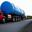

In [ ]:
from IPython.display import Image as IPyImage, display
display(IPyImage(filename='/content/cifake/test/FAKE/888 (10).jpg'))